# Select dispatching rules using decision trees

This notebook presents an implementation of a decision tree for dynamically selecting dispatching rules based on the system state.

# Prepare programming environment

## Load necessary packages

In [1]:
# Import packages
import time
import sys
import shap
import pandas as pd
import seaborn as sns
import pickle
from tqdm.notebook import tqdm
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from joblib import dump, load
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from time import mktime

tqdm.pandas()

sys.path.append("..")
from src.models import train_pipeline_model, evaluate_pipeline, optimize_hyperparameters, plot_learning_curve
from src.utils import get_hyperparameter_number
from src.simulation import assign_priority_edd, assign_priority_mdd, assign_priority_spt, assign_priority_srpt,assign_priority_lpt, assign_priority_cr, assign_priority_ds, assign_priority_fifo, run_simulation_complete

## Get required data

In [2]:
# Load the training data
with open(r"../data/processed/data_processed_classification_training.pickle", "rb") as output_file:
    data_train = pickle.load(output_file)

In [3]:
# Load the validation data
with open(r"../data/processed/data_processed_classification_validation.pickle", "rb") as output_file:
    data_validation = pickle.load(output_file)

In [4]:
# Load data required for simulation
product_types_df = pd.read_csv("../data/external/product_types.csv")
product_types_df = product_types_df[product_types_df.id != 2]
with open(r"../data/interim/sim_data.pickle", "rb") as output_file:
    orders_df = pickle.load(output_file)
machines_df = pd.read_csv("../data/external/machine.csv")
machines_df = machines_df[machines_df.product_type_id != 2]

## Define constants

In [5]:
# Define constants for model training
RANDOM_STATE = 42
numeric_features = list(data_train.columns)
numeric_features.remove("priority_rule_start")
numeric_features.remove("priority_rule_score")
categorical_features = ["priority_rule_start"]

In [6]:
# Define constants for simulation
priority_rules = {"edd": assign_priority_edd,
                  "spt": assign_priority_spt,
                  "srpt": assign_priority_srpt,
                  "fifo": assign_priority_fifo,
                  "cr": assign_priority_cr,
                  "mdd": assign_priority_mdd,
                  "lpt": assign_priority_lpt,
                  "ds": assign_priority_ds}
SIMULATION_START = mktime(datetime(2022, 11, 14, 5, 0, 0).timetuple()) * 1000
due_date_range_list = [(3, 10), (5, 14), (7, 21)]
number_orders_start_list = [80, 90, 100, 110]
average_count_new_orders_list = [80, 90, 100, 110]
worker_list = [40, 50, 60, 70]
random_states = [100, 101, 102]

# Prepare data

In [7]:
# Define features and flag
X = data_train.drop("priority_rule_score", axis=1)
y = data_train[["priority_rule_score"]]
X_validate = data_validation.drop("priority_rule_score", axis=1)
y_validate = data_validation[["priority_rule_score"]]

In [8]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

# Model training

## Baseline

In [9]:
# Simple dummy classifier based on the maximization of the prior probability
dummy = DummyClassifier(strategy="prior", random_state=42)
dummy_fit = dummy.fit(X_train, y_train)
print(f"Accuracy of the dummy classifier is: {round(dummy_fit.score(X_test, y_test), 4)}")

Accuracy of the dummy classifier is: 0.2418


In [10]:
# Simple logistic regression baseline without hyperparameter tuning and feature selection
lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, n_jobs=-1)
pipeline_lr = train_pipeline_model(lr, X_train, y_train, numeric_features, categorical_features)
evaluate_pipeline(pipeline_lr, X_test, y_test)

Start at 10:42:6
Duration: 12.127792835235596
Start at 10:42:18
Accuracy: 0.46142578125
F1: 0.43263465330364026
Precision: 0.44603803103803535
Recall: 0.42746990199377655
Duration: 0.20761513710021973


Based on the baseline we can already see that this is a performance improvement compared to the dummy baseline, which is an indicator, that the problem can be solved using classification methods.

## Hyperparameter search

In [11]:
# Define set of hyperparameters
params_dt = {
    'classifier__max_depth': [5, 10, 20, 50],
    'classifier__min_samples_leaf': [2, 5, 10, 20, 50, 100],
    'classifier__min_samples_split': [4, 10, 20, 50, 100, 200],
    'classifier__criterion': ["gini", "entropy", "log_loss"],
    'classifier__max_features': ["sqrt", "log2"],
    'classifier__splitter': ["best", "random"],
    'feature_selection__max_features': [10, 20, 50, None]
}
print(f"Set of {get_hyperparameter_number(params_dt)} hyperparameters")

Set of 6912 hyperparameters


Based on the variables we executed a grid hyperparameter search using successful halving.

In [12]:
# Fit hyperparameter search
model = DecisionTreeClassifier(random_state=RANDOM_STATE)
feature_selector = SelectFromModel(
    LogisticRegression(penalty="l1", solver="saga", random_state=RANDOM_STATE, max_iter=1000))
# fitted_clf = optimize_hyperparameters(X_train, y_train, model, feature_selector,numeric_features, categorical_features, params_dt, RANDOM_STATE)
# print(fitted_clf.best_params_)
# pd.DataFrame(fitted_clf.cv_results_).to_csv("../data/processed/results_hyperparameter_decision_tree.csv", index = False")

The grid search was executed and took 73181.71 seconds. The results are saved in a dataframe and can be read in as a csv file.

In [13]:
# Load results
results_hyperparameter = pd.read_csv("../data/processed/hyperparameter_search/results_hyperparameter_decision_tree.csv")

The resulting set of optimal hyperparameter were:
**Decision Tree**
* criterion="gini"
* max_depth=20,
* max_features="sqrt"
* min_samples_leaf=10
* min_samples_split=50
* splitter="best"

**Feature Selector**
* penalty="l1"
* solver="saga"
* max_iter=1000

## Train final model

Train model for evaluation based on the select hyperparameter.

In [14]:
# Train pipeline based on hyperparameter
final_model = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion="gini", max_depth=20,
                                     max_features="sqrt", min_samples_leaf=10, min_samples_split=50, splitter="best")
final_feature_selector = SelectFromModel(LogisticRegression(penalty="l1", solver="saga",
                                                            random_state=RANDOM_STATE, max_iter=1000))
# pipeline_trained = train_pipeline_model(final_model, X_train, y_train, numeric_features, categorical_features, final_feature_selector)

In [15]:
# Save model
# dump(pipeline_trained, '../models/pipeline_dispatching_classification_decision_tree_training.joblib')

In [16]:
# Load trained model
pipeline_trained = load('../models/pipeline_dispatching_classification_decision_tree_training.joblib')

## Model evaluation

In [17]:
# Evaluate pipeline on train
evaluate_pipeline(pipeline_trained, X_train, y_train)

Start at 10:42:19
Accuracy: 0.5367838541666666
F1: 0.5223312505596182
Precision: 0.5293555356257755
Recall: 0.5172573727934786
Duration: 0.7889811992645264


In [18]:
# Evaluate pipeline on test
evaluate_pipeline(pipeline_trained, X_test, y_test)

Start at 10:42:19
Accuracy: 0.3987630208333333
F1: 0.3813660315903556
Precision: 0.38695812598014584
Recall: 0.3775616192582274
Duration: 0.17375731468200684


We can already see that the model quality sinks significantly which shows overfitting of the model on the training dataset.

In [19]:
# Plot learning curve based on data samples and fitting time
# May take some seconds to calculate
# plot_learning_curve(pipeline_trained, "Evaluation training set decision tree", X, y.values.ravel(), axes=None, ylim=None, cv=None,n_jobs=-1, scoring="accuracy", train_sizes=np.linspace(0.1, 1.0, 5))

We can see that there is major gap in the performance of train and test that is not really closing with increasing data resources. However, it seems like more data could further improve the models.

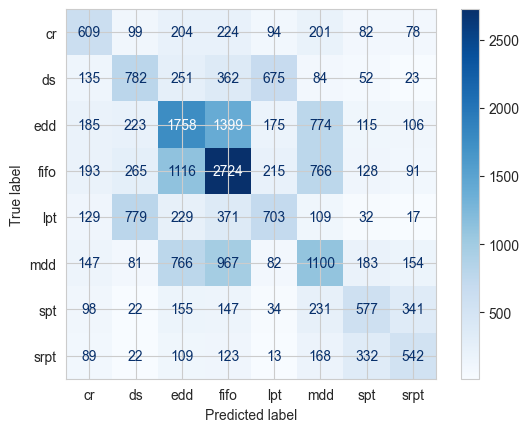

In [20]:
# Plot a confusion matrix
ConfusionMatrixDisplay.from_estimator(
    pipeline_trained,
    X_validate,
    y_validate,
    cmap=plt.cm.Blues)

Based on the confusion matrix we can see that there are some classes that get confused more than others. These classes do not necessarily reflect the identified co-occurring best performing dispatching rules from the preprocessing notebook. This is an indicator for a not optimal model.

In [21]:
# Create explainer for the final model
explainer = shap.TreeExplainer(pipeline_trained["classifier"])
shap.initjs()

In [22]:
# Preprocess data to calculate shap values
X_validate_processed = pipeline_trained["preprocessor"].transform(X_validate)
X_validate_selected = pipeline_trained["feature_selection"].transform(X_validate_processed)
shap_values = explainer.shap_values(X_validate_selected)

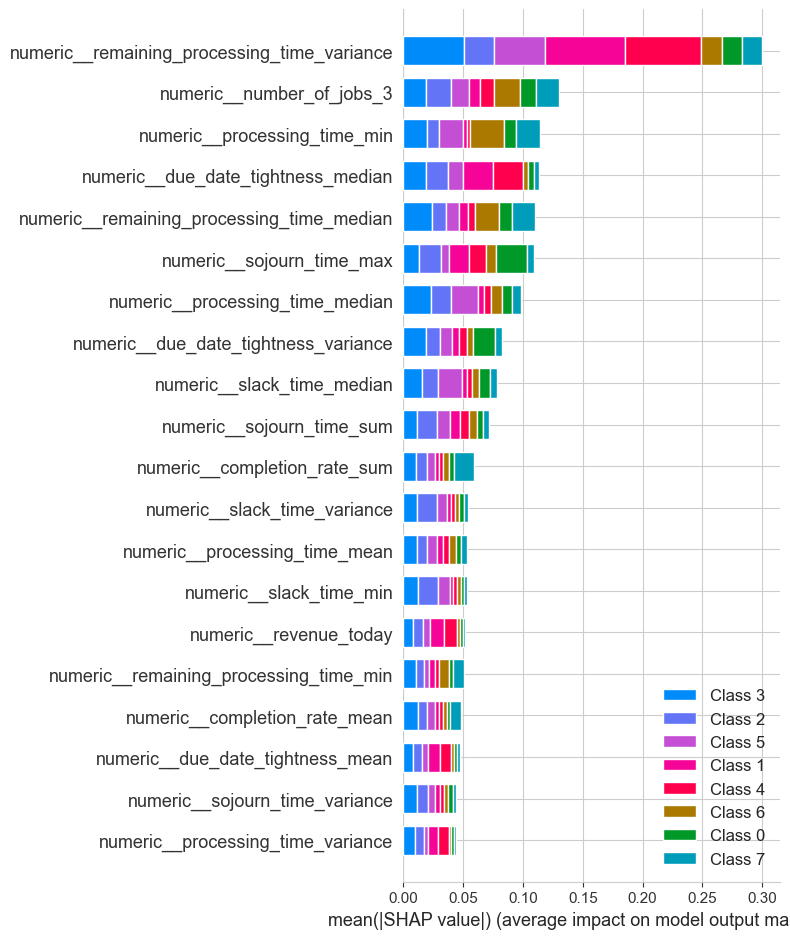

In [23]:
# Create a summary plot of the impact
feature_names = pipeline_trained["preprocessor"].get_feature_names_out(X_validate.columns)[
    pipeline_trained["feature_selection"].get_support()]
shap.summary_plot(shap_values, X_validate_selected, feature_names=feature_names)

When analysing the most important features we see many variables comprising the processing times. The two most important variables may be a surprise, as they display very specific measure. For the second variable it can be explained as the number of orders of the third product type is high that they are an important potential bottleneck which has to be taken care of. The measure of variance of processing times could be an indicator for how good different metrics based on the processing times will work.

## Train full model

Train the full model based on all available data.

In [24]:
# Create combined dataset for training the final model
X_complete = pd.concat([X, X_validate])
y_complete = pd.concat([y, y_validate])

In [25]:
# Train pipeline based on hyperparameter
final_model = DecisionTreeClassifier(random_state=RANDOM_STATE, criterion="gini", max_depth=20, max_features="sqrt",
                                     min_samples_leaf=10, min_samples_split=50, splitter="best")
final_feature_selector = SelectFromModel(LogisticRegression(penalty="l1", solver="saga",
                                                            random_state=RANDOM_STATE, max_iter=1000))
# pipeline_trained = train_pipeline_model(final_model, X_train, y_train, numeric_features, categorical_features, final_feature_selector)
# Save model
# dump(pipeline_trained, '../models/pipeline_dispatching_classification_decision_tree_complete.joblib')

In [26]:
# Load trained model
pipeline_simulation = load('../models/pipeline_dispatching_classification_decision_tree_complete.joblib')

# Evaluation in simulation environment

In this section we define a simulation testing environment for testing and comparing the performance of different approaches. For this we create use repeated simulation of a factory with varying experiment settings. The trained algorithm are then used in the process to select dispatching rules.

In [27]:
# Execute simulation
# Duration ~ 8 minutes
# simulation_results = run_simulation_complete(pipeline_simulation, priority_rules, random_states, due_date_range_list,
#                                             number_orders_start_list,
#                                             average_count_new_orders_list, worker_list, "Decision Tree Classification",
#                                             product_types_df, machines_df, orders_df, SIMULATION_START)

In [28]:
# Save simulation results
# simulation_results.to_csv("../data/processed/simulation_results_validation_classification_decision_tree.csv", index = False)

In [29]:
# Load simulation results
simulation_results = pd.read_csv(
    "../data/processed/evaluation/simulation_results_validation_classification_decision_tree.csv")

In [30]:
# Analyse simulation results profit
simulation_results["profit"] = simulation_results["revenue"] - simulation_results["penalty"]
print(f"Average profit is: {simulation_results.profit.mean()}")

Average profit is: 7395.766287008737


<AxesSubplot: xlabel='day', ylabel='profit'>

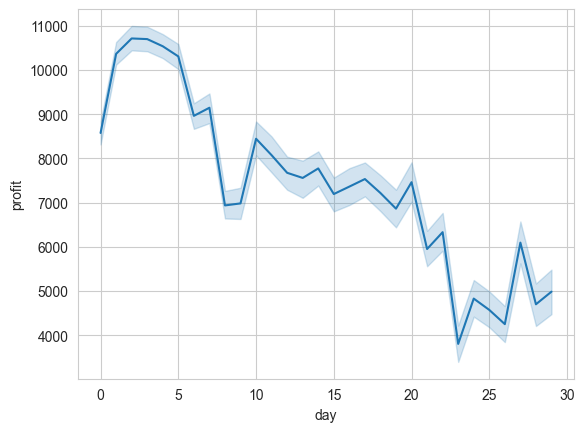

In [31]:
# Visualize profit
sns.lineplot(simulation_results, x="day", y="profit")

<AxesSubplot: xlabel='day', ylabel='profit'>

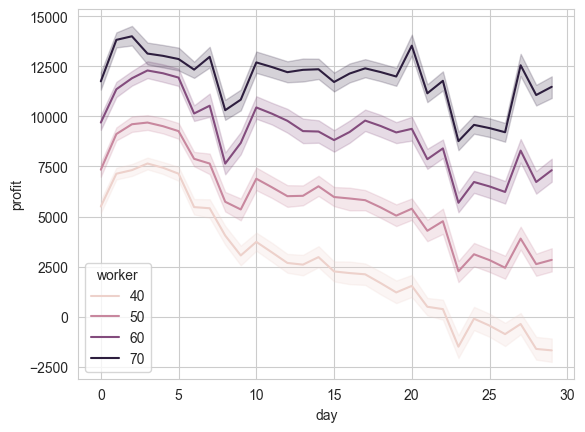

In [32]:
# Visualize profit per worker constellation
sns.lineplot(simulation_results, x="day", y="profit", hue="worker")

<AxesSubplot: xlabel='day', ylabel='profit'>

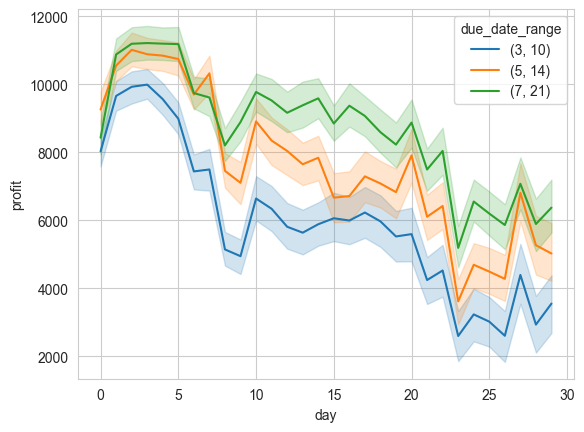

In [33]:
# Visualize profit per due date constellation
sns.lineplot(simulation_results, x="day", y="profit", hue="due_date_range")

<AxesSubplot: xlabel='day', ylabel='profit'>

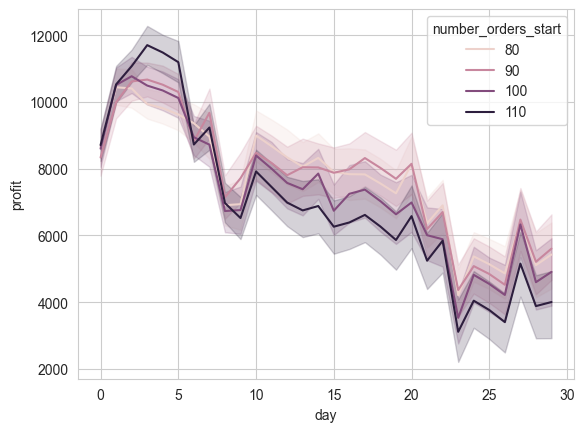

In [34]:
# Visualize profit per number_orders_start constellation
sns.lineplot(simulation_results, x="day", y="profit", hue="number_orders_start")

<AxesSubplot: xlabel='day', ylabel='profit'>

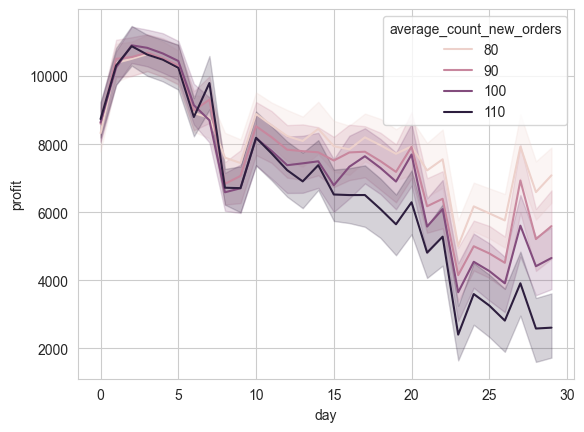

In [35]:
# Visualize profit per average count new orders constellation
sns.lineplot(simulation_results, x="day", y="profit", hue="average_count_new_orders")